In [1]:
from matplotlib import ticker as mtick
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/superstore-dataset-final/Sample - Superstore.csv


<a id="section_one"></a>
# <b style='font-size:0.8em'> 1. Getting to know the Data 💾</b>

In [2]:
data = pd.read_csv("/kaggle/input/superstore-dataset-final/Sample - Superstore.csv", encoding='cp1252')
data.head(3)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.96,2,0.0,41.9136
1,2,CA-2016-152156,11/8/2016,11/11/2016,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.94,3,0.0,219.5820
2,3,CA-2016-138688,6/12/2016,6/16/2016,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.62,2,0.0,6.8714


In [3]:
#Converting to date time
data["Order Date"], data["Ship Date"] = pd.to_datetime(data["Order Date"]), pd.to_datetime(data["Ship Date"])

print(f"""The data from this particular store spans over {(data['Order Date'].max() - data['Order Date'].min()).days} days with sales totaling at ${data['Sales'].sum() :,.0f} and a profit of ${data['Profit'].sum() :,.0f}.
There are {data['Product ID'].nunique()} unique articles in their inventory which are divided into {data['Category'].nunique()} categories, all of which are being sold across {data["State"].nunique()} states in the US.""")

The data from this particular store spans over 1457 days with sales totaling at $2,297,201 and a profit of $286,397.
There are 1862 unique articles in their inventory which are divided into 3 categories, all of which are being sold across 49 states in the US.


<a id="data_clean"></a>
## <b style='font-size:0.8em'>  🔨 Cleaning the Data </b>

In [4]:
#First lets clean the column names so it's all in snakecase and no whitespace.
data.columns = data.columns.str.replace(" ", "_").str.lower()
data.columns

Index(['row_id', 'order_id', 'order_date', 'ship_date', 'ship_mode',
       'customer_id', 'customer_name', 'segment', 'country', 'city', 'state',
       'postal_code', 'region', 'product_id', 'category', 'sub-category',
       'product_name', 'sales', 'quantity', 'discount', 'profit'],
      dtype='object')

In [5]:
#Dropping some redundant columns (for this analysis)
data = data.drop(columns=["row_id", "customer_name"])

In [6]:
#There is one duplicated entry in the dataset. Let's check it out
data[data.duplicated()]

,order_id,order_date,ship_date,ship_mode,customer_id,segment,country,city,state,postal_code,region,product_id,category,sub-category,product_name,sales,quantity,discount,profit
3406,US-2014-150119,2014-04-23,2014-04-27,Standard Class,LB-16795,Home Office,United States,Columbus,Ohio,43229,East,FUR-CH-10002965,Furniture,Chairs,Global Leather Highback Executive Chair with P...,281.372,2,0.3,-12.0588


In [7]:
#Given the structure of the dataset I will assume that this is a faulty entry.
data = data.drop_duplicates()

<a id="section_two"></a>
# <b style='font-size:0.8em'> 2. Product Analysis 🛒</b>

Text(0.0, 1.0, 'Share of Total Profit by Category')

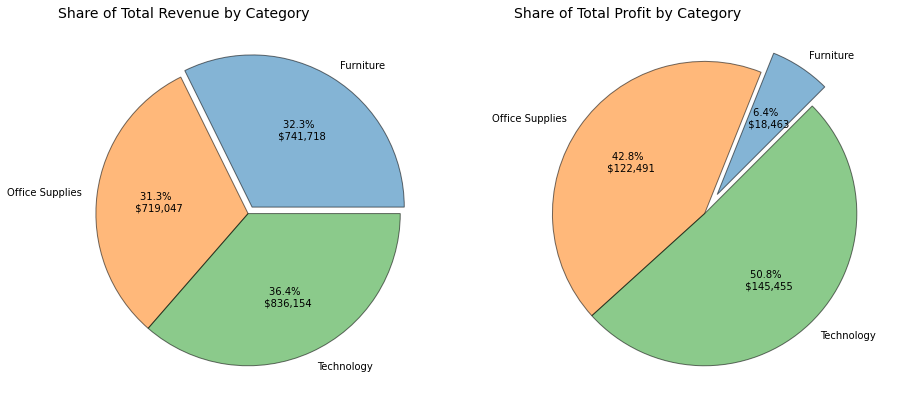

In [8]:
#Grouoping the dat based on category.
sales_per_category = data.groupby("category").sum()

#Getting a list of colors. This will help other charts use the same colors given the label texts.
category_colors = ["tab:blue" if label == "Furniture" else "tab:orange" if label == "Office Supplies" else "tab:green" for label in sales_per_category.index]
    

fig, (ax1, ax2) = plt.subplots(figsize=(15, 15), ncols=2)

#Making a pie chart of sales per category.
ax1.pie(sales_per_category["sales"], labels=sales_per_category.index,
      autopct=lambda p:f"{p:.1f}% \n ${p*np.sum(sales_per_category['sales'])/100 :,.0f}",
      wedgeprops={"linewidth": 1, "edgecolor":"black", "alpha":0.55},
      colors=category_colors, explode=[0.05, 0, 0])

#Setting the title
ax1.set_title("Share of Total Revenue by Category", loc="left", fontdict={"fontsize":14})

#Making a pie chart of profit per category.
ax2.pie(sales_per_category["profit"], labels=sales_per_category.index,
       autopct=lambda p: f"{p:.1f}% \n ${p*np.sum(sales_per_category['profit'])/100 :,.0f}",
        startangle=45, wedgeprops={"linewidth": 1, "edgecolor":"black", "alpha":0.55},
        colors=category_colors, explode=[0.15, 0, 0])

#Setting the title.
ax2.set_title("Share of Total Profit by Category",loc="left", fontdict={"fontsize":14})


<div style='font-size:1.1em; color: black'>
An interesting insight of the pie charts above is that sales are divided almost equally between the product categories. However, looking at each product category's share of the profit it becomes obvious that the margin on Furniture is quite low in comparision to Office Supplies and Technology.
    <br>
Given this insight - let's take a look at the sub-categories and it's respective margin.
</div>

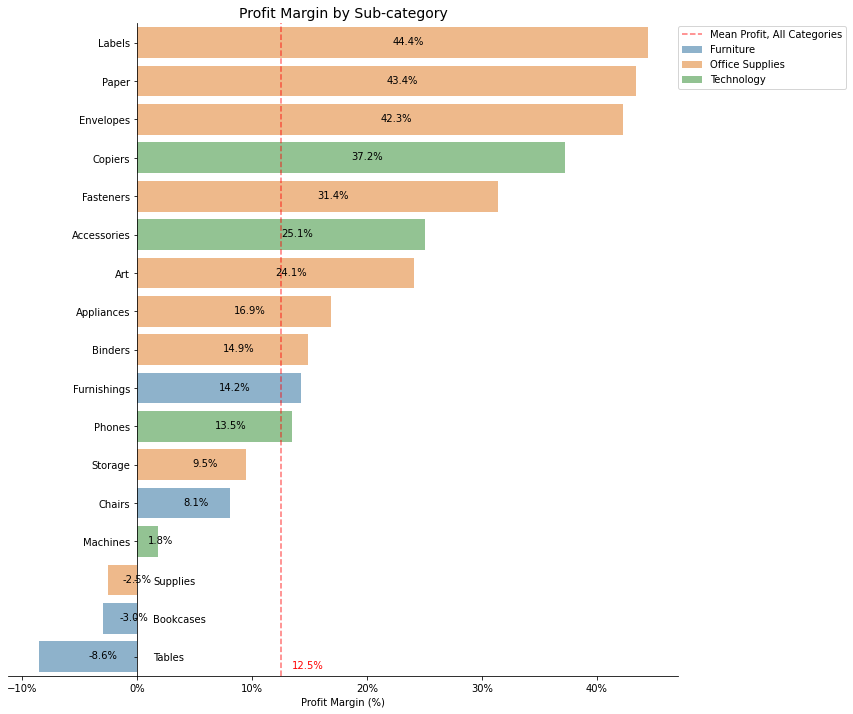

In [9]:
#Grouping the data on category and it's respective sub-categories. Calculating the profit margin.
sales_per_subcategory = data.groupby(["category", "sub-category"], as_index=False)[["sales", "profit"]].sum()
sales_per_subcategory["profit_margin"] = sales_per_subcategory["profit"] / sales_per_subcategory["sales"]

#Sorting the dataframe based on profit margin
sales_per_subcategory.sort_values(by="profit_margin", inplace=True, ascending=False)

fig, ax = plt.subplots(figsize=(12,12))

#Plotting the profit margin per sub-category.
sns.barplot(y=sales_per_subcategory["sub-category"], x=sales_per_subcategory["profit_margin"], hue=sales_per_subcategory["category"], 
            hue_order=["Furniture", "Office Supplies", "Technology"], alpha=0.55, dodge=False,
           ax=ax)

#Cleaning out bar junk
ax.spines["left"].set_position("zero")
ax.spines[["right","top"]].set_visible(False)
ax.set(ylabel=None, xlabel="Profit Margin (%)")


def move_ylabel_tick(index: list):
    """
    Moving the provided ylabel ticks
    """
    for tick in index:
        ax.get_yticklabels()[tick].set_x(0.02)
        ax.get_yticklabels()[tick].set_horizontalalignment("left")

#Moving the y-labels on sub-categories that are making a loss in order to prevent collision of the bar and the text.
move_ylabel_tick([-1, -2, -3])


#Annotating the profit margin amount for each bar.
for p in ax.patches:
    _, y = p.get_xy()
    
    ax.annotate(f"{p.get_width()*100 :.1f}%", (p.get_width() / 2, y+0.45))
    
#Calculating Superstore's aggregate profit margin in order to compare it to each sub-category's profit margin
mean_profit = sales_per_subcategory["profit"].sum() / sales_per_subcategory["sales"].sum()

#Plotting a vertical line and annotating the Superstore's aggregate profit margin.
ax.axvline(mean_profit, color="red", label="Mean Profit, All Categories", alpha=0.55, ls="--")
ax.text(x=mean_profit+0.01, y=len(sales_per_subcategory)-0.7, s=f"{mean_profit*100 :.1f}%", color="red")

#Setting the title and legend.
ax.set_title("Profit Margin by Sub-category", fontdict={"fontsize":14})
ax.legend(loc=(1, 0.9))

#Formatting the x-axis as %
ax.xaxis.set_major_formatter(mtick.PercentFormatter(1.0))

In [10]:
#Creating a dataframe for each sub-category and it's respective products.
tables = data.groupby(["sub-category", "product_name"]).sum().loc["Tables",:]
bookcases = data.groupby(["sub-category", "product_name"]).sum().loc["Bookcases",:]
supplies = data.groupby(["sub-category", "product_name"]).sum().loc["Supplies",:]


def profit_margin(category_df):
    """
    Function to calculate the profit margin for all the provided dataframes
    """
    
    category_df["profit_margin"] = category_df["profit"] / category_df["sales"]
    
    category_df.sort_values(by="profit_margin", inplace=True, ascending=False)
    
    return category_df

#Calculating profit margin for all dataframes.
profit_margin(tables)
profit_margin(bookcases)
profit_margin(supplies)

#
def profitable_items(category_dict: dict):
    """
    Function to print the amount of items that have a higher profit margin than the company average
    """
    
    for df_name, df in category_dict.items():

        print(f"""{df_name} has {len(df[df['profit_margin'] > mean_profit])} items (out of {len(df)}) with a profit margin higher than the company average.""")
    
profitable_items({"Tables":tables, "Bookcases":bookcases, "Supplies":supplies})


Tables has 2 items (out of 56) with a profit margin higher than the company average.
Bookcases has 6 items (out of 50) with a profit margin higher than the company average.
Supplies has 23 items (out of 36) with a profit margin higher than the company average.


In [11]:
#Converting to floats from scientific notation
supplies["profit"] = supplies["profit"].apply(lambda x: f"{x:.2f}")
supplies["profit_margin"] = supplies["profit_margin"].apply(lambda x: f"{x:.2f}")

supplies.sort_values(by="sales", ascending=False)[:5]

,postal_code,sales,quantity,discount,profit,profit_margin
product_name,,,,,,
High Speed Automatic Electric Letter Opener,266895,17030.312,11,0.2,-262.00,-0.02
Martin Yale Chadless Opener Electric Letter Opener,277104,16656.200,22,0.6,-1299.18,-0.08
Compact Automatic Electric Letter Opener,354385,2982.750,26,0.4,-57.27,-0.02
Premier Automatic Letter Opener,195746,2836.366,14,0.6,-427.86,-0.15
Premier Electric Letter Opener,405429,2641.608,24,0.6,-0.00,-0.00


<div style='font-size:1.1em; color: black'>
As shown, the 5 highest selling items within Supplies are being sold at a negative margin. This in turn has brought down the profit margin for the entire sub-category.
</div>

<a id="section_three"></a>
# <b style='font-size:0.8em'> 3. Segment Analysis 💼</b>

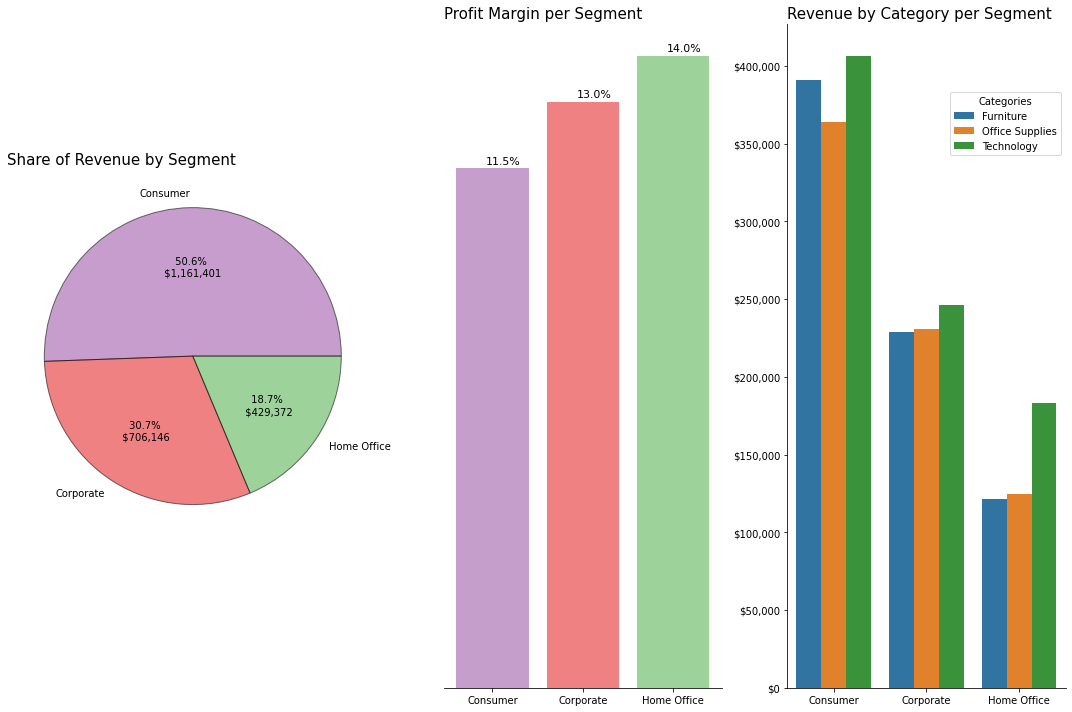

In [12]:
#Grouping by segment and summing the numerical cols.
sales_by_segment = data.groupby("segment").sum()

#Using this the same colors can be applied for the segments across different charts.
segment_colors = ["#984ea3" if label == "Consumer" else "#e41a1c" if label == "Corporate" else "#4daf4a" for label in sales_by_segment.index]

fig, (ax1, ax2, ax3) = plt.subplots(figsize=(15,10), ncols=3, gridspec_kw={"width_ratios": [1, 0.75, 0.75]})

#Pie chart with % share of revenue and annotating the actual sales value.
ax1.pie(sales_by_segment["sales"], labels=sales_by_segment.index,
       wedgeprops={"linewidth":1, "edgecolor":"black", "alpha":0.55}, colors=segment_colors,
      autopct=lambda p: f"{p: .1f}% \n ${p*np.sum(sales_by_segment['sales'])/100 :,.0f}")

#Setting the title for the pie chart
ax1.set_title("Share of Revenue by Segment", fontdict={"fontsize":15}, loc="left")

#Preparing the data for visualization in a bar chart.
sales_by_segment["profit_margin"] = sales_by_segment["profit"] / sales_by_segment["sales"]
sales_by_segment = sales_by_segment[["quantity", "profit", "profit_margin"]].reset_index()

#Visualizing the profit margin per segment and applying the same coloring as the as pie chart.
ax2.bar(x=sales_by_segment["segment"], height=sales_by_segment["profit_margin"],
           color=segment_colors, alpha=0.55)

#Removing bar junk
ax2.spines[["left", "top", "right"]].set_visible(False)
ax2.tick_params(left=None, labelleft=None)

#Annotating the bars.
for p in ax2.patches:
    x, _ = p.get_xy()
    
    ax2.annotate(f"{p.get_height()*100 :.1f}%", xy=(x+0.33, p.get_height()+0.001), size=11)

#Setting title for the bar chart.
ax2.set_title("Profit Margin per Segment", fontdict={"fontsize":15}, loc="left")

#Grouping by segment and category.
segment_and_category = data.groupby(["segment", "category"], as_index=False).sum()

#Plotting the sales per segment and using the category as hue to show the division of sales between the categories.
sns.barplot(x=segment_and_category["segment"], y=segment_and_category["sales"], hue=segment_and_category["category"], ax=ax3)

#Removing bar junk.
ax3.spines[["top", "right"]].set_visible(False)
ax3.set_title("Revenue by Category per Segment", fontdict={"fontsize":15}, loc="left")
ax3.set(xlabel=None, ylabel=None)

#Setting the format to USD on the y-axis.
ax3.yaxis.set_major_formatter("${x:,.0f}")

#Legend for the bar chart to show the segments in hue.
ax3.legend(title="Categories", loc="center right", bbox_to_anchor=(1, 0.85))

fig.tight_layout()

<a id="section_four"></a>
# <b style='font-size:0.8em'> 4. Geographical Analysis 🌍</b>

Text(0.5, 1.0, 'Revenue per State - Top 10')

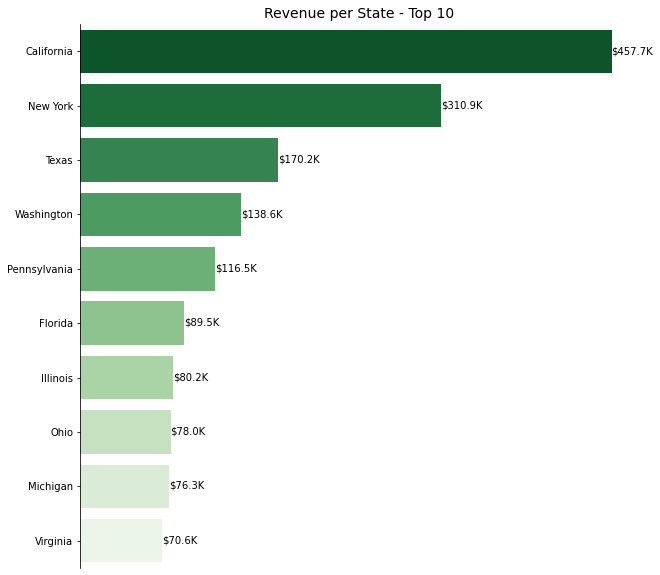

In [13]:
#Grouping the data on state and sorting it based on the sales the states are making
sales_by_state = data.groupby("state", as_index=False).sum().sort_values(by="sales", ascending=False)

#Calculating profit margin per state.
sales_by_state["profit_margin"] = sales_by_state["profit"] / sales_by_state["sales"]


fig, ax = plt.subplots(figsize=(10,10))

#Plotting the sales per state.
sns.barplot(x=sales_by_state["sales"][:10], y=sales_by_state["state"][:10],
           ax=ax, palette="Greens_r")

#Annotating the sales.
for p in ax.patches:
    _, y = p.get_xy()
    
    ax.annotate(f"${p.get_width() / 1000 :.1f}K", xy=(p.get_width(), y+0.45))
    
#Removing bar junk
ax.spines[["top", "right", "bottom"]].set_visible(False)
ax.set(ylabel=None, xlabel=None)
ax.tick_params(labelbottom=None, bottom=None)

#Setting the title
ax.set_title("Revenue per State - Top 10", fontdict={"fontsize":14})

<div style='font-size:1.1em; color: black'>
The drop of in sales between states is quite large as California has 50% more sales than New York (2nd highest by sales) and New York has 80% more sales than Texas (3rd highest by sales).
 <br>
This company is therefore reliant on keeping up the sales in these 3 geographical segments (out of all the 49 states they've been selling to).
</div>

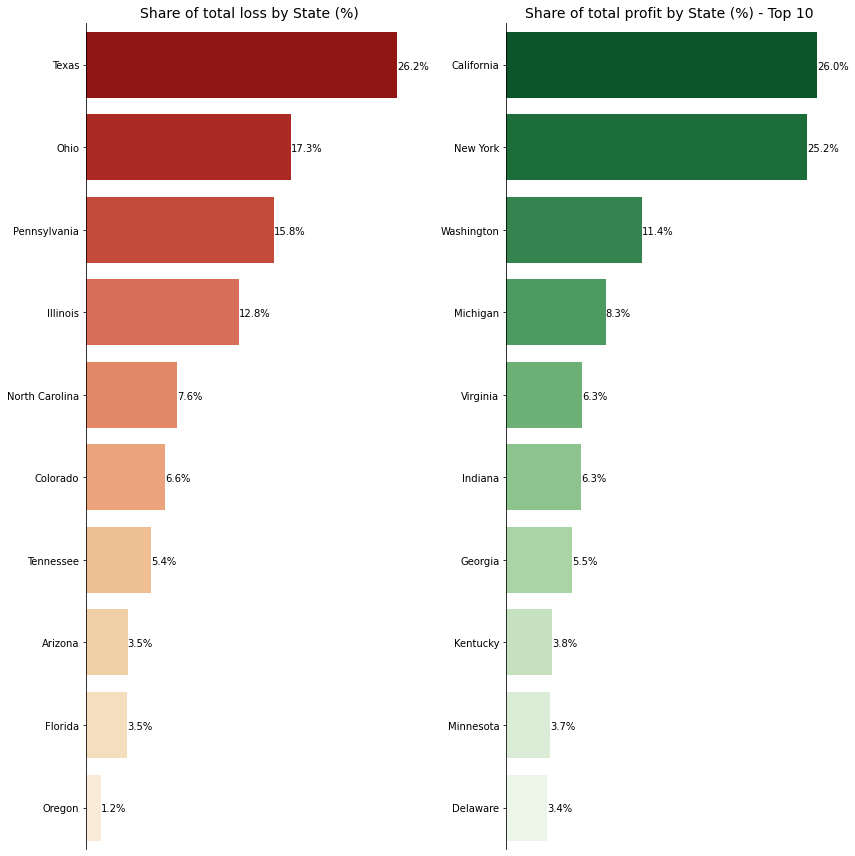

In [14]:
#Filtering to only show states that on aggregate are making a loss. Sorting with the lowest values.
no_profit_states = sales_by_state[sales_by_state["profit"] < 0].sort_values(by="profit")[:10]

#Getting each state's share of the total loss.
no_profit_states["share_of_loss"] = no_profit_states["profit"] / no_profit_states["profit"].sum()

#Filtering to only show states that on aggregate are making a profit. Sorting with the highest values first.
profitable_states = sales_by_state[sales_by_state["profit"] > 0].sort_values(by="profit", ascending=False)[:10]

#Getting each state's share of the total profit.
profitable_states["share_of_profit"] = profitable_states["profit"] / profitable_states["profit"].sum()

fig, (ax1, ax2) = plt.subplots(figsize=(12, 12), ncols=2)

#Plotting the states where Superstore is making a loss.
sns.barplot(x=no_profit_states["share_of_loss"], y=no_profit_states["state"], 
            ax=ax1, palette="OrRd_r")

#Plotting the states where Superstore is making a profit
sns.barplot(x=profitable_states["share_of_profit"], y=profitable_states["state"],
           ax=ax2, palette="Greens_r")


def clean_hbar(ax):
    """
    Function to clean out bar junk for the provided bar charts
    """
    
    ax.spines[["bottom" ,"top", "right"]].set_visible(False)
    ax.set(ylabel=None, xlabel=None)
    ax.tick_params(bottom=False, labelbottom=False)
    
    return ax

def annotate_hbar(ax):
    """
    Function to annotate the % share of profit/loss on the provided bar charts"""
    
    for p in ax.patches:
        _, y = p.get_xy()
        ax.annotate(f"{p.get_width()*100 :.1f}%", xy=(p.get_width(), y+0.45))
    
    return ax

#Calling the function on the two charts.
annotate_hbar(ax1)
annotate_hbar(ax2)
    
#Calling the function on the two charts.
clean_hbar(ax1)
clean_hbar(ax2)
    
#Setting the title for the two charts.
ax1.set_title("Share of total loss by State (%)", fontdict={"fontsize":14})
ax2.set_title("Share of total profit by State (%) - Top 10", fontdict={"fontsize":14})

fig.tight_layout()

<div style='font-size:1.1em; color: black'>
 An important finding here is that some of the states where this company is making most of their sales is actually bringing down the profit that this company is making.
    <br> 
 Texas for instace, which is their 3rd highest segment in terms of sales, is actually contributing to more than 1/4 of the loss that the company is making on it's sales.

In [15]:
#Grouping by order and sub-category. Therefore all sub-categories within a order will be shown.
grouped_order = data.groupby(["order_id", "sub-category"]).sum()

#Creating dataframes where we have Tables and Bookcases within the orders.
#These will be used for the inverse masking function below.
orders_with_tables = grouped_order.xs("Tables", level="sub-category")
orders_with_bookcases = grouped_order.xs("Bookcases", level="sub-category")

def filter_df(df_to_filter, filtration_dfs: list):
    """
    Filters a dataframe based on the index of other dataframe(s).
    
    -----
    Parameters
    df_to_filter: The DataFrame that will be filtered
    
    filtration_dfs: DataFrame(s) used for filtering
    
    -----
    Returns
    Filtered DataFrame
    """
    
    #Reseting the index of the provided df to filter.
    df_to_filter = df_to_filter.reset_index()
    
    #Iterating over the dataframes and inverse masking the dataframe. 
    #Doing this we remove all the orders where atleast one purchase is being made from Tables and Bookcases
    for frame in filtration_dfs:
        df_to_filter = df_to_filter[~df_to_filter["order_id"].isin(frame.index)]
    
    return df_to_filter

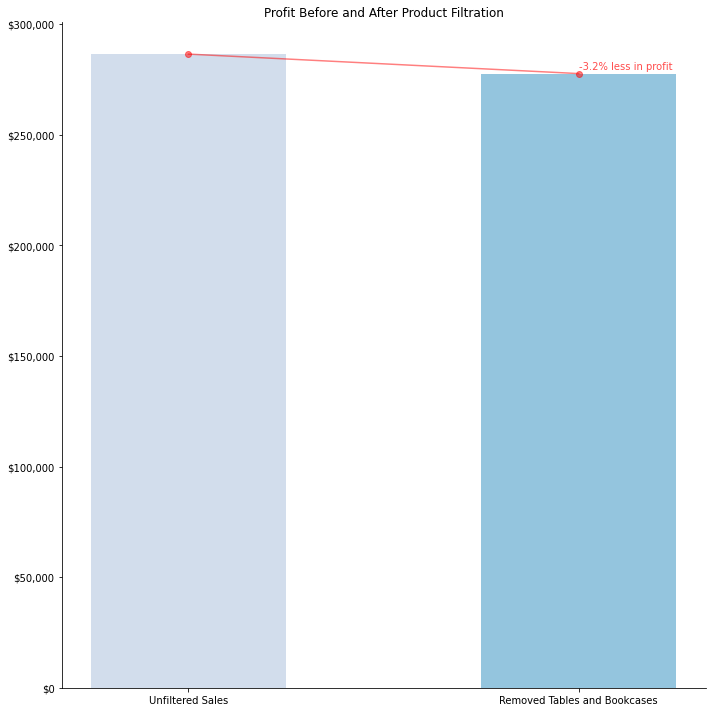

In [16]:
#Calling the function on the df that is grouped on customer orders.
filtered_df = filter_df(grouped_order, [orders_with_bookcases, orders_with_tables])

fig, ax = plt.subplots(figsize=(10,10))

#For visualizing the difference in sales.
ax.bar(x="Unfiltered Sales", height=data["profit"].sum(), width=0.5, color="#a6bddb", alpha=0.5)
ax.bar(x="Removed Tables and Bookcases", height=filtered_df["profit"].sum(), width=0.5, color="#2b8cbe", alpha=0.5)

#To show the % difference in profit given that we removed some sub-categories.
ax.plot(["Unfiltered Sales", "Removed Tables and Bookcases"], [data["profit"].sum(), filtered_df["profit"].sum()],
        ls="-", marker="o", color="red", alpha=0.5)

#Annotating the difference
ax.annotate(f"{(filtered_df['profit'].sum() - data['profit'].sum()) / filtered_df['profit'].sum() * 100 :.1f}% less in profit",
           xy=(1, filtered_df["profit"].sum() + 2000),
           color="red", alpha=0.7)

#Bar junk
ax.spines[["top","right"]].set_visible(False)

#Setting the y-axis to USD.
ax.yaxis.set_major_formatter("${x:,.0f}")

#Setting the title
ax.set_title("Profit Before and After Product Filtration")

fig.tight_layout()